In [25]:
import pyarrow.parquet as pq
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import keras
print(keras.__version__)
from keras import backend as K
import tensorflow as tf
print(tf.__version__)
from keras.callbacks import LambdaCallback,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from math import sqrt
from sklearn.metrics import confusion_matrix,f1_score,matthews_corrcoef,fbeta_score,precision_score,recall_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn
from sklearn.utils import class_weight
from datetime import datetime,timedelta

2.3.1
2.0.0-rc1


In [2]:
df = pq.read_table(source='integratedData.parquet.gz').to_pandas()
display(df.head())

,date,precipitation_amount_mm,relative_humidity_%,specific_humidity_kg/kg,surface_downwelling_shortwave_flux_in_air_W m-2,wind_from_direction_Degrees Clockwise from north,wind_speed_m/s,max_air_temperature_K,min_air_temperature_K,burning_index_g_Unitless,dead_fuel_moisture_100hr_Percent,dead_fuel_moisture_1000hr_Percent,energy_release_component-g_Unitless,potential_evapotranspiration_mm,mean_vapor_pressure_deficit_kPa,fire_occurred,acres_burned,fire_name,longitude,latitude
0,1999-01-01,0.0,40.3,0.00589,138.0,123.0,1.6,293.1,281.1,24.0,16.0,15.5,34.0,1.7,0.74,False,NaN,None,-117.975000,33.566667
1,1999-01-01,0.0,39.8,0.00590,137.2,123.0,1.6,293.1,281.2,24.0,16.0,15.5,35.0,1.7,0.74,False,NaN,None,-117.933333,33.566667
2,1999-01-01,0.0,38.2,0.00580,137.2,123.0,1.7,293.2,281.2,26.0,15.2,14.9,37.0,1.7,0.77,False,NaN,None,-117.891667,33.566667
3,1999-01-01,0.0,36.4,0.00567,137.3,49.0,1.8,293.3,280.3,27.0,15.0,14.8,38.0,1.8,0.76,False,NaN,None,-117.850000,33.566667
4,1999-01-01,0.0,33.8,0.00538,137.3,49.0,1.9,293.2,279.9,29.0,13.3,13.6,43.0,1.9,0.80,False,NaN,None,-117.808333,33.566667


In [3]:
###********Check Fire occured in Months to drop some months of data********
fire_occured_df = df[df['fire_occurred']==True]
month_list = [0,0,0,0,0,0,0,0,0,0,0,0]
for item in fire_occured_df['date']:
    month_list[item.month-1] = month_list[item.month-1]+ 1;
print ("Fire Occurence in Each month across years")
print (month_list)

Fire Occurence in Each month across years
[14, 13, 9, 6, 217, 122, 296, 148, 87, 1220, 6, 29]


In [4]:
df_sorted = df.sort_values(['latitude', 'longitude','date'], ascending=[True,True,True])
df_sorted['month'] = df_sorted.apply(lambda row: row.date.month, axis = 1)
df_sorted['day']   = df_sorted.apply(lambda row: row.date.day, axis = 1)
#df_upd = df_sorted[(df_sorted['month']>4) & (df_sorted['month']<11)]

In [5]:
df_upd = df_sorted.reindex(columns= ['precipitation_amount_mm','relative_humidity_%','specific_humidity_kg/kg', \
 'surface_downwelling_shortwave_flux_in_air_W m-2','wind_from_direction_Degrees Clockwise from north', \
 'wind_speed_m/s','max_air_temperature_K', 'min_air_temperature_K','burning_index_g_Unitless', \
 'dead_fuel_moisture_100hr_Percent','dead_fuel_moisture_1000hr_Percent','energy_release_component-g_Unitless', \
 'potential_evapotranspiration_mm','mean_vapor_pressure_deficit_kPa',
 'longitude','latitude','month','day','fire_occurred','acres_burned','fire_name','date'])
df_upd.fire_occurred = df_sorted.fire_occurred.astype(int)
df_upd.head()

,precipitation_amount_mm,relative_humidity_%,specific_humidity_kg/kg,surface_downwelling_shortwave_flux_in_air_W m-2,wind_from_direction_Degrees Clockwise from north,wind_speed_m/s,max_air_temperature_K,min_air_temperature_K,burning_index_g_Unitless,dead_fuel_moisture_100hr_Percent,...,potential_evapotranspiration_mm,mean_vapor_pressure_deficit_kPa,longitude,latitude,month,day,fire_occurred,acres_burned,fire_name,date
1268,0.0,49.5,0.00653,155.3,348.0,2.6,290.7,281.0,26.0,17.2,...,1.7,0.47,-117.141667,32.483333,1,1,0,NaN,None,1999-01-01
2660,0.0,54.3,0.00656,157.5,358.0,2.3,291.3,281.1,24.0,17.2,...,1.7,0.51,-117.141667,32.483333,1,2,0,NaN,None,1999-01-02
4052,0.0,41.1,0.00581,160.8,38.0,3.3,293.4,279.9,29.0,16.8,...,2.4,0.73,-117.141667,32.483333,1,3,0,NaN,None,1999-01-03
5444,0.0,23.9,0.00437,160.7,62.0,2.3,295.4,281.9,28.0,14.6,...,2.6,1.20,-117.141667,32.483333,1,4,0,NaN,None,1999-01-04
6836,0.0,24.1,0.00556,160.7,347.0,2.5,294.4,282.2,30.0,13.2,...,2.4,0.94,-117.141667,32.483333,1,5,0,NaN,None,1999-01-05


In [6]:
undersample_grid_dict= {}
with open('log.txt', 'w') as f:
    lats = sorted(set(df_upd.latitude.values))
    lons = sorted(set(df_upd.longitude.values))

    loc_count = 0
    Fire_loc_count = 0
    NoFire_loc_count = 0
    for i in lats:
        for j in lons:
            mask = (df_upd['latitude']==i) & (df_upd['longitude']==j)
            if not df_upd[mask].empty:
                loc_count += 1;
                if 1 in df_upd[mask]['fire_occurred'].values:
                    Fire_loc_count += 1;
                else:
                    if i not in undersample_grid_dict.keys():
                        undersample_grid_dict[i] = []
                    if j not in undersample_grid_dict[i]:
                        undersample_grid_dict[i].append(j)
#                     print ("Dropping all data at ",i,j,file=f)
#                     df_upd.drop(sorted(df_upd[mask].index),inplace=True)
                    NoFire_loc_count += 1;

    print("Total grids are ",loc_count)
    print("Grids that had Fire", Fire_loc_count)
    print("Grids that didn't have Fire", NoFire_loc_count)

Total grids are  890
Grids that had Fire 478
Grids that didn't have Fire 412


In [7]:
undersample_grid_dict

{32.483333333333334: [-117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.97499996666667],
 32.525000000000006: [-117.18333330000002,
  -117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.97499996666667,
  -116.64166663333334,
  -116.59999996666667,
  -116.55833330000002,
  -116.51666663333334,
  -116.47499996666667,
  -116.43333330000002],
 32.56666666666667: [-117.18333330000002,
  -117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.47499996666667,
  -116.43333330000002,
  -116.22499996666667,
  -116.18333330000002,
  -116.14166663333334,
  -116.09999996666667,
  -116.05833330000002],
 32.608333333333334: [-117.18333330000002,
  -117.14166663333334,
  -117.09999996666667,
  -117.05833330000002,
  -117.01666663333334,
  -116.97499996666667],
 32.650000000000006: [-117.26666663333334,
  -117.22499996666667,
  -117.18333330000002,
  -117.14166663333334,


In [8]:
df_upd.shape

(6826300, 22)

In [9]:
df_mod = df_upd.reset_index(drop=True)
#df_mod = df_upd

In [10]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
x =     df_mod[df_mod.columns[~df_mod.columns.isin(['fire_occurred','acres_burned','fire_name','date'])]].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x)
#norm_Df = pd.DataFrame(data = norm_x, columns = columns)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [11]:
#This function is called upon if the seq has fire and accordingly adds it to that fire group
def append_to_fire_seq(fire_dict,i,df_mod,lag):
#    print (i,len(fire_dict))
    idx = i + np.where(df_mod.iloc[i:i+lag]['fire_occurred']==1)[0][0]
    fire_name = df_mod.iloc[idx]['fire_name']
    check_date = pd.Timestamp.to_datetime64(df_mod.iloc[idx]['date'])
    if fire_name!=None:
        fire_name = str(df_mod.iloc[idx]['date'].year) + "_" + fire_name.lower() 
        if fire_name not in fire_dict.keys():
            fire_dict[fire_name] = []
#         if len(fire_dict[fire_name])!=0:
#             check_date2 = fire_dict[fire_name][0][0][-1]
#             #if ((check_date2-check_date).astype('timedelta64[D]')/np.timedelta64(1, 'D')) < -20:
#             if (check_date2 - check_date).days < -30:
#                 print ("Pls check this fire list", fire_name , "Seems fires occured more than 30 days apart")
        fire_dict[fire_name].append(df_mod.iloc[idx-lag:idx].values)
        fire_dict[fire_name].append(df_mod.iloc[idx]['fire_occurred'])
    else:
        print ("No Name for this fire happened in from ",idx-lag)

In [12]:
def undersample(lat,lon,year,month):
    undersample_grid_year_dict = {}
    if lat in undersample_grid_dict.keys():
        if lon in undersample_grid_dict[lat]:  #Grid never had fire. Let's add only one seq per month
            if (lat,lon) not in undersample_grid_year_dict.keys():
                undersample_grid_year_dict[(lat,lon)]= {}
            if year not in undersample_grid_year_dict[(lat,lon)].keys():
                undersample_grid_year_dict[(lat,lon)][year] = []   #This month and year for this Grid is seen first time.
            if month not in undersample_grid_year_dict[(lat,lon)][year]:
                undersample_grid_year_dict[(lat,lon)][year].append(month)
                #print (lat,lon,year,month)
                return 1
            else:
                return 0
    return 1    

In [13]:
#This function breaks the total dataset into small sequences
def create_seq(df_mod,lag):    
    print ("Every sequence will be",lag, "days long asking LSTM to predict a fire based on past",lag,"days of weather")
    global nofire_X,nofire_y,fire_dict
    nofire_X = []
    nofire_y = []
    fire_dict = {}
    for i in range(0,df_mod.shape[0],lag):
        if i+lag in df_mod.index:
            fire_occur_list = list(df_mod.iloc[i:i+lag].fire_occurred.values)
            if fire_occur_list.count(1)==1:          #Fire in Sequence
                append_to_fire_seq(fire_dict,i,df_mod,lag)
            elif fire_occur_list.count(1)==0:        #No Fire in Sequence
                if undersample(df_mod.iloc[i]['latitude'],df_mod.iloc[i]['longitude'],df_mod.iloc[i]['date'].year,df_mod.iloc[i]['month'])==1:
                    nofire_X.append(df_mod.iloc[i:i+lag].values)
                    nofire_y.append(df_mod.iloc[i+lag]['fire_occurred'])
            else:                                   #More than one fire in sequence. Maybe same or different fires
                indices = np.where(df_mod.iloc[i:i+lag]['fire_occurred']==1)[0]
                for item in indices:
                    append_to_fire_seq(fire_dict,i+item,df_mod,lag)
        else:
            print ("Can't create sequence from this index onwards", i)

In [14]:
#This function is called to retrieve sequences of a specific fire
def add_fire_seq_train_test (fire_names):
    X_list= []
    for fire in fire_names:
        for idx in range(0,len(fire_dict[fire]),2):
            X_list.append(fire_dict[fire][idx])
            if fire_dict[fire][idx+1]!=1:
                print ("Error: This is unexpected. Check the fire sequence for fire ", fire)
    return X_list

In [15]:
#This function is called to shuffle sequences of fire with no fire
def comb_fire_and_nofire(nofire_X_train,fire_X_train,nofire_y_train,fire_y_train):
    a_len = len(nofire_X_train)
    b_len = len(fire_X_train)
    a_cnt = -1
    b_cnt = -1
    out_x_list = []
    out_y_list = []
    my_list = [0]*len(nofire_X_train) + [1]*len(fire_X_train)
    random.shuffle(my_list)
    for i in my_list:
        if i==0:
            a_cnt += 1
            out_x_list.append(nofire_X_train[a_cnt])
            out_y_list.append(nofire_y_train[a_cnt])
        else:
            #print (a_cnt,b_cnt)
            b_cnt += 1
            out_x_list.append(fire_X_train[b_cnt])
            out_y_list.append(fire_y_train[b_cnt])
    return out_x_list,out_y_list

In [16]:
def train_test_partition(test_year):
    nofire_X_train = []
    nofire_X_test  = []
    nofire_y_train = []
    nofire_y_test  = []
    test_fire_list = []
    train_fire_list = []
    for idx,seq in enumerate(nofire_X):
        if seq[0,-1].year==test_year:
            nofire_X_test.append(seq)
            nofire_y_test.append(nofire_y[idx])
        else:
            nofire_X_train.append(seq)
            nofire_y_train.append(nofire_y[idx])
    for item in sorted(fire_dict.keys()):
        if int(item.split('_')[0]) == test_year:
            test_fire_list.append(item)
        else:
            train_fire_list.append(item)
    fire_X_train = []
    fire_X_test  = []
    fire_X_train = fire_X_train + add_fire_seq_train_test(train_fire_list)
    fire_X_test = fire_X_test + add_fire_seq_train_test(test_fire_list)
    fire_y_train = [1] * len(fire_X_train)
    fire_y_test  = [1] * len(fire_X_test)
    print ("No. of Fires in Train set are", len(train_fire_list))
    print ("No. of Fire sequences in Train set are", len(fire_X_train))
    print ("No. of no-fire sequences in Train set are", len(nofire_X_train))
    print ("No. of Fires in Test set are", len(test_fire_list))
    print ("No. of Fire sequences in Test set are", len(fire_X_test))
    print ("No. of no-fire sequences in Test set are", len(nofire_X_test))
    print ("Fires in Test are",test_fire_list)
    A,B = comb_fire_and_nofire(nofire_X_train,fire_X_train,nofire_y_train,fire_y_train)
    C,D = comb_fire_and_nofire(nofire_X_test,fire_X_test,nofire_y_test,fire_y_test)
    return A,B,C,D

In [17]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [18]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [19]:
def train_model(X_train,X_test,y_train,y_test,input_node,hidden_node,hidden_node1,dropout,class_weight,loss_funtion,alpha,gamma,lag):
    input=()
    ##Build LSTM Model
    global model
    model = Sequential()
    model.add(LSTM(input_node, input_shape=(X_train[0].shape),activation='relu'))
    model.add(Dense(hidden_node, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_node1, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation = 'softmax'))
    if (loss_funtion=='binary_crossentropy'):
        model.compile(loss='binary_crossentropy', optimizer='adam')     
    else:
        model.compile(loss=binary_focal_loss(alpha=alpha,gamma=gamma),optimizer='adam')
    #Fit the model
    train_label = np.array(y_train)
    y_invtrain = [1 - crap for crap in y_train]
    train_label_inv = np.array(y_invtrain)
    train_label_np = np.array((train_label_inv,train_label), order='F').T

    history = model.fit(np.array(X_train),train_label_np,
                            epochs=25,validation_split = 0.1,
                            verbose=2, shuffle=True,
                            callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)],
                            class_weight=class_weight)
    #Visualize Training
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training pattern')
    plt.legend()
    # make a prediction
    global y_pred, y_ppredt
    y_pred = model.predict(np.array(X_test))
    #Measure metrics
    y_ppredt=[]
    for i in y_pred:
        if i[0]<i[1]:
            y_ppredt.append(1)
        else:
            y_ppredt.append(0)
    f1 = f1_score(y_test, y_ppredt, average='macro')
    f2 = fbeta_score(y_test, y_ppredt, average='macro', beta=2)
    mcc = matthews_corrcoef(y_test, y_ppredt)
    disp = confusion_matrix(y_test,y_ppredt,labels=[1,0])
    with open("test.csv", "a") as myfile:
        temp_string = "Building LSTM of lag\t" + str(lag) + ";" \
                      "with input_node\t" + str(input_node)  + ";" \
                      "and hidden_node\t" + str(hidden_node) + ";" \
                      "and hidden_node1\t" + str(hidden_node1) + ";" \
                      "and dropout\t" + str(dropout) + "," \
                      "and class_weight\t" + str(class_weight) + ";" \
                      "and loss_funtion\t" + str(loss_funtion) + ";" \
                      "of alpha\t" + str(alpha) + ";"\
                      "and gamma\t" + str(gamma) + ";" \
                      "and received F1_Score:\t" + str(f1) + ";" \
                      "and received F2_Score:\t" + str(f2) + ";" \
                      "and MCC_Score:\t" + str(mcc) + ";" \
                      "of CM\t" + str(disp).replace('\n', '') + ";" + "\n"
        myfile.write(temp_string)
        print (temp_string)
    skplt.metrics.plot_confusion_matrix(y_test, y_ppredt,labels=[1,0])
    plt.show()

In [20]:
def test_model(df_sorted,scaler):
    lats = sorted(set(df_test.latitude.values))
    lons = sorted(set(df_test.longitude.values))

    loc_count = 0
    for k in lats:
        for j in lons:
            mask = (df_test['latitude']==k) & (df_test['longitude']==j)
            if not df_test[mask].empty:
                loc_array = []
                loc_count += 1;
                #print ("Processing" + str(loc_count) + " " + str(k) + " " + str(j))
                for i in range(0,df_test[mask].shape[0]-lag,1):
                    seq = df_test[mask][i:i+lag][df_test.columns[~df_test.columns.isin(['fire_occurred','acres_burned','fire_name','date','predicted_fire_risk'])]].values
                    temp = scaler.transform(seq)
                    temp = np.column_stack((temp, np.zeros(10,int)[:,None]))
                    loc_array.append(temp)
                y_pred_year = model.predict(np.array(loc_array))
                y_ppredt_year=[]
                for i in y_pred_year:
                    if i[0]<i[1]:
                        y_ppredt_year.append(1)
                    else:
                        y_ppredt_year.append(0)
                df_test.loc[df_test[mask].index,'predicted_fire_risk'] = [0]*lag + y_ppredt_year  
    print ("For Test year", test_year)
    print ("F1 Score" ,f1_score(df_test['fire_occurred'], df_test['predicted_fire_risk'], average='macro'))
    print ("F2 Score" ,fbeta_score(df_test['fire_occurred'], df_test['predicted_fire_risk'], average='macro', beta=2))
    print ("F1 Score Bin" ,f1_score(df_test['fire_occurred'], df_test['predicted_fire_risk'], average='binary'))
    print ("F2 Score Bin" ,fbeta_score(df_test['fire_occurred'], df_test['predicted_fire_risk'], average='binary', beta=2))
    print ("Precision", precision_score(df_test['fire_occurred'], df_test['predicted_fire_risk'], average='binary'))
    print ("Recall", recall_score(df_test['fire_occurred'], df_test['predicted_fire_risk'], average='binary'))
    print ("MCC Score",matthews_corrcoef(df_test['fire_occurred'], df_test['predicted_fire_risk']))
    skplt.metrics.plot_confusion_matrix(df_test['fire_occurred'], df_test['predicted_fire_risk'],labels=[1,0])        
    fire_occurred_dict = {}
    for i,row in df_test[df_test['fire_occurred']==1].iterrows():
        firee = row['fire_name'].lower()
        if firee not in fire_occurred_dict.keys():
            fire_occurred_dict[firee] = row['date']

    for fire in fire_occurred_dict.keys():
        warn_date = fire_occurred_dict[fire] - timedelta(days=10)
        filter = (df_test['date']>warn_date) & (df_test['date']<=fire_occurred_dict[fire])
        #display(df_test[filter])
        if 1 not in df_test[filter]['predicted_fire_risk'].values:
            print ("Missed warning about fire", fire)
        else:
            print ("\tWarned about fire", fire)

    #Check if we missed predicting any fire reporting in any grid before or when the fire started
    lats = sorted(set(df_test.latitude.values))
    lons = sorted(set(df_test.longitude.values))
    loc_count = 0
    for k in lats:
        for j in lons:
            if k == 32.56666666666667 and j==-116.84999996666667:
                mask = (df_test['latitude']==k) & (df_test['longitude']==j)
                if not df_test[mask].empty:
                    global df_sub
                    df_sub = df_test[mask]
                    fire_occurred_dict = {}
                    for i,row in df_sub[df_sub['fire_occurred']==1].iterrows():
                        firee = row['fire_name'].lower()
                        if firee not in fire_occurred_dict.keys():
                            fire_occurred_dict[firee] = row['date']
                            idx_loc = row.name - df_sub.iloc[0].name
                            if 1 not in (df_sub.iloc[idx_loc-10:idx_loc]['predicted_fire_risk'].values):
                                display (df_sub.iloc[idx_loc-10:idx_loc])
                                print (str(k) + " " + str(j) + " Missed Fire " + firee)

In [21]:
lag = 10
create_seq(df_mod,lag)

Every sequence will be 10 days long asking LSTM to predict a fire based on past 10 days of weather
Can't create sequence from this index onwards 6826290


In [22]:
for test_year in range(2003,2004,1):
    X_train,y_train,X_test,y_test = train_test_partition(test_year)
    #Normalize the train datset
    X_train_norm = []
    for seq in X_train:
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_train_norm.append(temp)

    #Normalize the train datset
    X_test_norm = []
    for seq in X_test:
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_test_norm.append(temp)

    temp = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    class_weight1 = dict(enumerate(temp))
    print (class_weight1)

    X_mod_test  = []
    X_mod_train = []
    y_mod_test  = []
    y_mod_train = []
    for idx,val in enumerate(X_train_norm):
        if np.any(val[:,17] == 1):
            val[:,17] = 0
        if np.any(val[:,17] != 1):
            X_mod_train.append(val)
            y_mod_train.append(y_train[idx])        

    for idx,val in enumerate(X_test_norm):
        if np.any(val[:,17] == 1):
            val[:,17] = 0
        if np.any(val[:,17] != 1):
            X_mod_test.append(val)
            y_mod_test.append(y_test[idx]) 
            
    global df_test
    df_test = df_sorted.reindex(columns= ['precipitation_amount_mm','relative_humidity_%','specific_humidity_kg/kg', \
     'surface_downwelling_shortwave_flux_in_air_W m-2','wind_from_direction_Degrees Clockwise from north', \
     'wind_speed_m/s','max_air_temperature_K', 'min_air_temperature_K','burning_index_g_Unitless', \
     'dead_fuel_moisture_100hr_Percent','dead_fuel_moisture_1000hr_Percent','energy_release_component-g_Unitless', \
     'potential_evapotranspiration_mm','mean_vapor_pressure_deficit_kPa',
     'longitude','latitude','month','day','fire_occurred','acres_burned','fire_name','date'])
    df_test.fire_occurred = df_sorted.fire_occurred.astype(int)
    df_test = df_test[df_test.date.dt.year==test_year]
    df_test = df_test.reset_index(drop=True)
    df_test["predicted_fire_risk"] = np.nan

No. of Fires in Train set are 280
No. of Fire sequences in Train set are 1993
No. of no-fire sequences in Train set are 649643
No. of Fires in Test set are 14
No. of Fire sequences in Test set are 174
No. of no-fire sequences in Test set are 31867
Fires in Test are ['2003_border#2', '2003_border#5', '2003_cedar', '2003_coyote', '2003_dehesa', '2003_dunbar', '2003_grade', '2003_jewell', '2003_mine/otay', '2003_mountain', '2003_paradise', '2003_range', '2003_roblar 2', '2003_sycamore']
{0: 0.501579472400798, 1: 158.78070175438597}


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 586472 samples, validate on 65164 samples
Epoch 1/25
 - 86s - loss: 0.0096 - val_loss: 0.0092
Epoch 2/25
 - 90s - loss: 0.0072 - val_loss: 0.0079
Epoch 3/25
 - 92s - loss: 0.0069 - val_loss: 0.0076
Epoch 4/25
 - 87s - loss: 0.0064 - val_loss: 0.0094
Epoch 5/25
 - 85s - loss: 0.0063 - val_loss: 0.0088
Epoch 6/25
 - 86s - loss: 0.0066 - val_loss: 0.0100
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping
Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 200};and loss_funtion	focal_loss;of alpha	0.15;and gamma	2;and received F1_Score:	0.5036177256879434;and received F2_Score:	0.5026935872266847;and MCC_Score:	0.014701240159624011;of CM	[[    1   173] [   20 31847]];



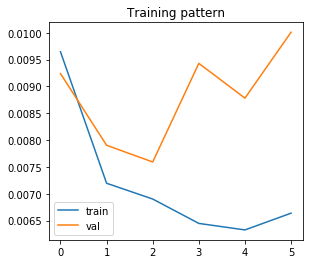

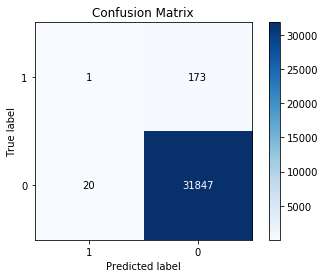

For Test year 2003
F1 Score 0.4998506557291234
F2 Score 0.4999217755833878
F1 Score Bin 0.0
F2 Score Bin 0.0
Precision 0.0
Recall 0.0
MCC Score -0.00018165044348536353


NameError: name 'timedelta' is not defined

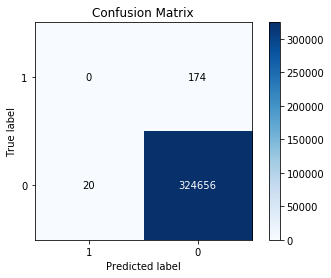

In [23]:
train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,10,10,10,0.1,{0:0.5,1:200},'focal_loss',0.15,2,lag)
test_model(df_sorted,scaler)

Train on 586472 samples, validate on 65164 samples
Epoch 1/25
 - 101s - loss: 0.3018 - val_loss: 0.3942
Epoch 2/25
 - 96s - loss: 0.2350 - val_loss: 0.2414
Epoch 3/25
 - 94s - loss: 0.2361 - val_loss: 0.2572
Epoch 4/25
 - 90s - loss: 2.1585 - val_loss: 0.3034
Epoch 5/25
 - 87s - loss: 0.2278 - val_loss: 0.3273
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping
Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 100};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.517506989034176;and received F2_Score:	0.5422538763911641;and MCC_Score:	0.1031547884372522;of CM	[[   67   107] [ 1798 30069]];



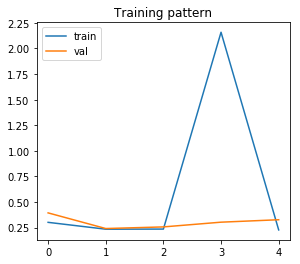

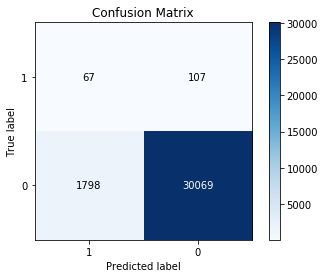

For Test year 2003
F1 Score 0.4924889507408645
F2 Score 0.4918969617452489
F1 Score Bin 0.00869507937553521
F2 Score Bin 0.02101509265745399
Precision 0.004397947624441927
Recall 0.3793103448275862
MCC Score 0.03673728271466126
	Warned about fire mine/otay
	Warned about fire border#2
	Warned about fire border#5
	Warned about fire jewell
	Warned about fire range
	Warned about fire cedar
	Warned about fire dehesa
	Warned about fire dunbar
	Warned about fire sycamore
	Warned about fire paradise
	Warned about fire grade
	Warned about fire coyote
	Warned about fire roblar 2
	Warned about fire mountain


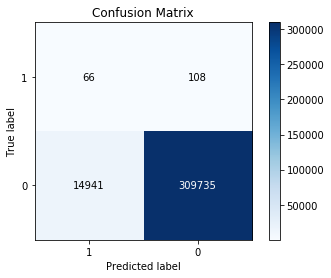

In [26]:
train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,10,10,10,0.1,{0:0.5,1:100},'binary_crossentropy',0,0,lag)
test_model(df_sorted,scaler)

Train on 586472 samples, validate on 65164 samples
Epoch 1/25
 - 88s - loss: 0.4737 - val_loss: 0.3787
Epoch 2/25
 - 89s - loss: 1.8408 - val_loss: 0.4611
Epoch 3/25
 - 88s - loss: 2.6053 - val_loss: 10.6675
Epoch 4/25
 - 87s - loss: 9.5767 - val_loss: 10.6675
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping
Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 200};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.44675968261290144;and received F2_Score:	0.43531272926335907;and MCC_Score:	0.08171579499471328;of CM	[[  125    49] [ 7682 24185]];



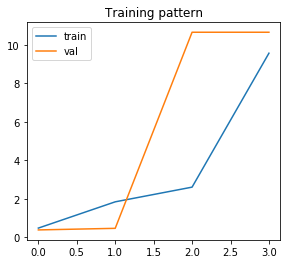

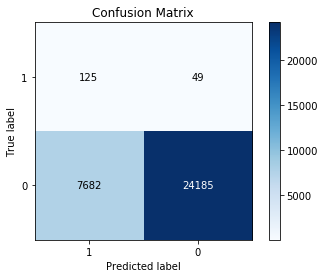

For Test year 2003
F1 Score 0.43907207001680654
F2 Score 0.41106868695243975
F1 Score Bin 0.0034183321847002066
F2 Score Bin 0.008484782132691044
Precision 0.0017132751188239195
Recall 0.7126436781609196
MCC Score 0.02725121519644343
	Warned about fire mine/otay
	Warned about fire border#2
	Warned about fire border#5
	Warned about fire jewell
	Warned about fire range
	Warned about fire cedar
	Warned about fire dehesa
	Warned about fire dunbar
	Warned about fire sycamore
	Warned about fire paradise
	Warned about fire grade
	Warned about fire coyote
	Warned about fire roblar 2
	Warned about fire mountain


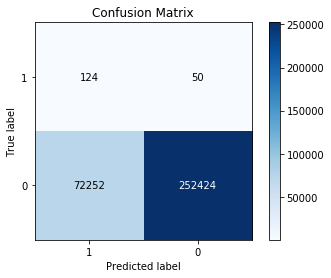

In [27]:
train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,10,10,10,0.1,{0:0.5,1:200},'binary_crossentropy',0,0,lag)
test_model(df_sorted,scaler)

Train on 586472 samples, validate on 65164 samples
Epoch 1/25
 - 88s - loss: 4.5286 - val_loss: 5.3337
Epoch 2/25
 - 88s - loss: 4.7883 - val_loss: 5.3337
Epoch 3/25
 - 90s - loss: 4.7883 - val_loss: 5.3337
Epoch 4/25
 - 83s - loss: 4.7883 - val_loss: 5.3337
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\sathishm\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Building LSTM of lag	10;with input_node	12;and hidden_node	12;and hidden_node1	12;and dropout	0.1,and class_weight	{0: 0.5, 1: 100};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.49863866808537277;and received F2_Score:	0.49945457623080836;and MCC_Score:	0.0;of CM	[[    0   174] [    0 31867]];



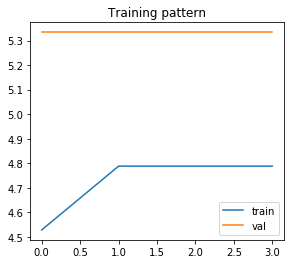

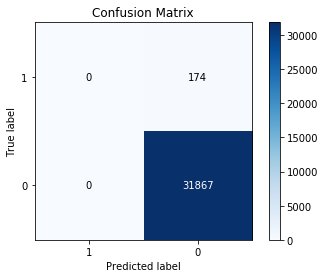

KeyboardInterrupt: 

In [29]:
train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,12,12,12,0.1,{0:0.5,1:100},'binary_crossentropy',0,0,lag)
test_model(df_sorted,scaler)

Train on 586472 samples, validate on 65164 samples
Epoch 1/25
 - 86s - loss: 8.8639 - val_loss: 10.6675
Epoch 2/25
 - 83s - loss: 2.1310 - val_loss: 0.4804
Epoch 3/25
 - 84s - loss: 4.1912 - val_loss: 10.6675
Epoch 4/25
 - 84s - loss: 8.8468 - val_loss: 10.6675
Epoch 5/25
 - 83s - loss: 9.5767 - val_loss: 10.6675
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping
Building LSTM of lag	10;with input_node	12;and hidden_node	12;and hidden_node1	12;and dropout	0.1,and class_weight	{0: 0.5, 1: 200};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.44311206645567824;and received F2_Score:	0.43271472958329055;and MCC_Score:	0.10609133749715599;of CM	[[  156    18] [ 8297 23570]];



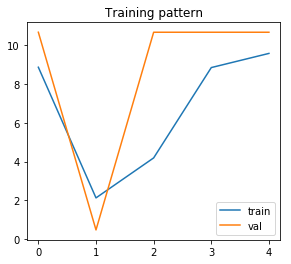

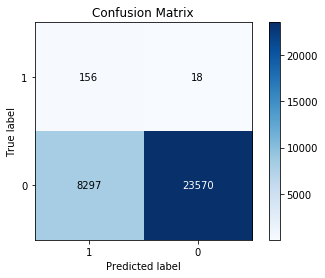

For Test year 2003
F1 Score 0.4236496661326578
F2 Score 0.3901346668934508
F1 Score Bin 0.003542877906976744
F2 Score Bin 0.00880500304788567
Precision 0.0017749459551712368
Recall 0.896551724137931
MCC Score 0.032620962033862645
	Warned about fire mine/otay
	Warned about fire border#2
	Warned about fire border#5
	Warned about fire jewell
	Warned about fire range
	Warned about fire cedar
	Warned about fire dehesa
	Warned about fire dunbar
	Warned about fire sycamore
	Warned about fire paradise
	Warned about fire grade
	Warned about fire coyote
	Warned about fire roblar 2
	Warned about fire mountain


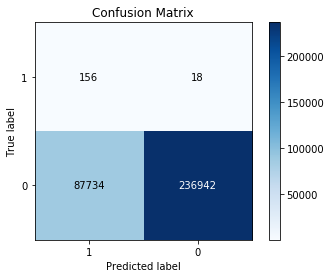

In [30]:
train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,12,12,12,0.1,{0:0.5,1:200},'binary_crossentropy',0,0,lag)
test_model(df_sorted,scaler)

(array([1.7000e+01, 0.0000e+00, 2.8500e+02, 0.0000e+00, 0.0000e+00,
        2.1520e+03, 0.0000e+00, 0.0000e+00, 9.3100e+02, 0.0000e+00,
        6.4150e+03, 0.0000e+00, 0.0000e+00, 8.8650e+03, 0.0000e+00,
        0.0000e+00, 1.8354e+04, 0.0000e+00, 0.0000e+00, 1.7603e+04,
        0.0000e+00, 1.5589e+04, 0.0000e+00, 0.0000e+00, 1.0840e+04,
        0.0000e+00, 0.0000e+00, 3.2780e+03, 0.0000e+00, 3.5610e+03]),
 array([ 1.        ,  1.36666667,  1.73333333,  2.1       ,  2.46666667,
         2.83333333,  3.2       ,  3.56666667,  3.93333333,  4.3       ,
         4.66666667,  5.03333333,  5.4       ,  5.76666667,  6.13333333,
         6.5       ,  6.86666667,  7.23333333,  7.6       ,  7.96666667,
         8.33333333,  8.7       ,  9.06666667,  9.43333333,  9.8       ,
        10.16666667, 10.53333333, 10.9       , 11.26666667, 11.63333333,
        12.        ]),
 <a list of 30 Patch objects>)

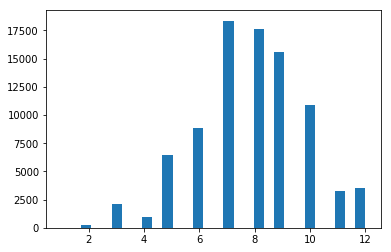

In [36]:
plt.hist(df_test[df_test['predicted_fire_risk']==1]['date'].dt.month,30)

In [59]:
temp1 = df_test[df_test['predicted_fire_risk']==1][['latitude','longitude','predicted_fire_risk']]
display(temp1.groupby(['latitude','longitude'], as_index=False)['predicted_fire_risk'].sum())

,latitude,longitude,predicted_fire_risk
0,32.483333,-117.141667,35.0
1,32.483333,-117.100000,57.0
2,32.483333,-117.058333,64.0
3,32.483333,-117.016667,61.0
4,32.483333,-116.975000,58.0
5,32.525000,-117.183333,35.0
6,32.525000,-117.141667,32.0
7,32.525000,-117.100000,53.0
8,32.525000,-117.058333,65.0
9,32.525000,-117.016667,61.0


In [ ]:
train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,12,12,12,0.1,None,'binary_crossentropy',0,0,lag)
test_model(df_sorted,scaler)

Train on 586472 samples, validate on 65164 samples
Epoch 1/25
 - 95s - loss: 0.0133 - val_loss: 0.0097
Epoch 2/25
 - 98s - loss: 0.0084 - val_loss: 0.0108
Epoch 3/25
 - 99s - loss: 0.0081 - val_loss: 0.0100
Epoch 4/25
